# Experiment analysis

How people fake? For how long? How others succeed (or fail) to detect faked behaviour?

In [1]:
import collections
import datetime
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
DATA_DIR = 'data'

In [3]:
def get_logs(data_dir):
    """
    Read all log files from disk.
    """
    logs = {}
    for directory in os.listdir(data_dir):
        session_path = os.path.join(data_dir, directory)
        assert os.path.isdir(session_path), f'{session_path} is not a directory'
        with open(os.path.join(session_path, 'experiment.log')) as f:
            logs[directory] = f.read().splitlines()
            
    return logs

In [4]:
class Event(collections.namedtuple('Event', ['session', 'timestamp', 'kind', 'data'])):

        __slots__ = ()
        
        def __str__(self):
            data_str = ' '.join(f'{key}={val}' for key, val in self.data.items())
            return f'{self.timestamp.time()} [{self.session}] {self.kind}: {data_str}'


def parse_player_event(url):
    player, *raw_event = url[1:].split('/')
    
    data = {'player': int(player)}
    
    kind = raw_event[0].replace('-', '_')
    
    if kind == 'participant_id':
        data['participant'] = int(raw_event[1])
    elif kind in ['talking', 'autopilot']:
        data['start'] = raw_event[1] == 'start'
    elif kind == 'accuse':
        data['accused_player'] = int(raw_event[1])
        data['correct'] = raw_event[2] == 'correct'
    elif kind == 'collect_token':
        pass  # Nothing to do here
    else:
        raise AssertionError(f"Event of kind {kind} was not expected")

    return kind, data


def parse_log_line(session, line):
    """
    Parse line to an Event.
    
    The log looks like this:
    15:48:12.254 [info] GET /1/participant-id/1
    15:48:21.245 [info] GET /1/talking/start
    15:48:21.267 [info] GET /1/talking/stop
    15:49:03.221 [info] GET /1/autopilot/start
    17:29:51.849 [info] POST /scores/reset-hard
    17:57:35.544 [info] POST /scores/reset-scores
    ...
    """
    timestamp, _, http_method, url = line.split()
    timestamp = datetime.datetime.strptime(timestamp, '%H:%M:%S.%f')

    if http_method == 'GET':
        kind, data = parse_player_event(url)
    elif http_method == 'POST':
        kind = 'reset_scores'
        data = {'hard': url.endswith('reset-hard')}
    else:
        raise AssertionError(f'{http_method} requests were not expected!')

    return Event(session, timestamp, kind, data)

In [5]:
def to_fractional_seconds(timedelta):
    return timedelta.seconds + timedelta.microseconds / 100_000

In [6]:
def add_participant_id(events):
    """
    Run through the events and add participant ID with latest data from events of kind `participant-id`.
    """
    player_id_to_participant_id = {}
    for event in events:
        if event.kind == 'participant_id':
            player_id_to_participant_id[event.data['player']] = event.data['participant']
        else:
            for prefix in ['', 'accused_']:
                player_key = prefix + 'player'
                participant_key = prefix + 'participant'
                if player_key in event.data:
                    event.data[participant_key] = player_id_to_participant_id[event.data[player_key]]

In [7]:
def add_accusation_time_from_autopilot(events):
    """
    The time passed since the accused participant started to autopilot.
    """
    player_id_to_start_autopilt = {}
    for event in events:
        if event.kind == 'autopilot' and event.data['start']:
            player_id_to_start_autopilt[event.data['player']] = event.timestamp
        if event.kind == 'accuse' and event.data['correct']:
            start_autopilot = player_id_to_start_autopilt[event.data['accused_player']]
            event.data['time_from_autopilot'] = to_fractional_seconds(event.timestamp - start_autopilot)

In [8]:
def add_time(events, kind):
    player_id_to_start = {}
    for event in events:
        if event.kind == kind and event.data['start']:
            player_id_to_start[event.data['player']] = event.timestamp
        if event.kind == kind and not event.data['start']:
            start_talking = player_id_to_start[event.data['player']]
            event.data['time'] = to_fractional_seconds(event.timestamp - start_talking)

In [9]:
def add_went_undetected(events):
    autopiloting_and_wasnt_detected = set()  # A set of player IDs
    for event in events:
        if event.kind == 'autopilot':
            if event.data['start']:
                autopiloting_and_wasnt_detected.add(event.data['player'])
            else:
                event.data['went_undetected'] = event.data['player'] in autopiloting_and_wasnt_detected
        elif event.kind == 'accuse' and event.data['correct']:
             if event.data['accused_player'] in autopiloting_and_wasnt_detected:
                    autopiloting_and_wasnt_detected.remove(event.data['accused_player'])

In [10]:
def process_logs_to_events(logs):
    all_events = []
    for session, log in logs.items():
        events = [parse_log_line(session, line) for line in log]
        add_participant_id(events)
        add_accusation_time_from_autopilot(events)
        add_went_undetected(events)
        add_time(events, 'talking')
        add_time(events, 'autopilot')
        all_events += events
    return all_events

In [11]:
logs = get_logs(DATA_DIR)
events = process_logs_to_events(logs)

# Events analysis

In [12]:
def to_dataframe(events, filter_):
    dicts = []
    for event in events:
        if (callable(filter_) and filter_(event)) or event.kind == filter_:
            dicts.append({
                'timestamp': event.timestamp,
                'session': event.session,
                **event.data
            })
    return pd.DataFrame(dicts).set_index('timestamp')

## Accusations

In [13]:
accusations = to_dataframe(events, 'accuse')

Time passed from autopilot start to accusation: mean 8.451407407407407, std 5.122929893233899


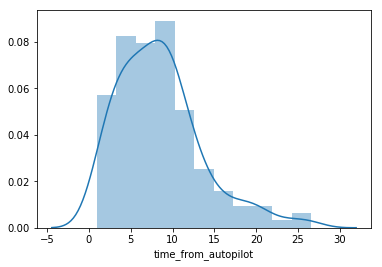

In [14]:
time_from_autopilot = accusations[accusations.correct].time_from_autopilot
sns.distplot(time_from_autopilot);
print(f'Time passed from autopilot start to accusation: mean {time_from_autopilot.mean()}, std {time_from_autopilot.std()}')

In [15]:
print(f'Ratio of correct accusations: {accusations.correct.mean()}')

Ratio of correct accusations: 0.24545454545454545


## Autopiloting

In [16]:
autopiloting = to_dataframe(events, filter_=lambda e: e.kind == 'autopilot' and not e.data['start'])

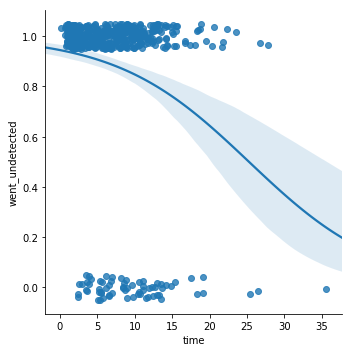

In [17]:
sns.lmplot(x='time', y='went_undetected', data=autopiloting, logistic=True, y_jitter=.05);

In [18]:
print(f'Ratio of undetected autopiloting: {autopiloting.went_undetected.mean()}')

Ratio of undetected autopiloting: 0.8759259259259259


## Next

Compare how much players talk to how much the autopilt. Does faking affect their performance in the conversation?